In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glomeruli-hubmap-external-1024x1024/masks_1024/SAS_21924_001_13.png
/kaggle/input/glomeruli-hubmap-external-1024x1024/masks_1024/SESCAM_9_0_25.png
/kaggle/input/glomeruli-hubmap-external-1024x1024/masks_1024/VUHSK_1432_75.png
/kaggle/input/glomeruli-hubmap-external-1024x1024/masks_1024/VUHSK_1762_29.png
/kaggle/input/glomeruli-hubmap-external-1024x1024/masks_1024/SESCAM_1_0_15.png
/kaggle/input/glomeruli-hubmap-external-1024x1024/masks_1024/SAS_21896_001_20.png
/kaggle/input/glomeruli-hubmap-external-1024x1024/masks_1024/VUHSK_1702_9.png
/kaggle/input/glomeruli-hubmap-external-1024x1024/masks_1024/SAS_21904_001_51.png
/kaggle/input/glomeruli-hubmap-external-1024x1024/masks_1024/VUHSK_1502_67.png
/kaggle/input/glomeruli-hubmap-external-1024x1024/masks_1024/VUHSK_1272_12.png
/kaggle/input/glomeruli-hubmap-external-1024x1024/masks_1024/VUHSK_1622_168.png
/kaggle/input/glomeruli-hubmap-external-1024x1024/masks_1024/VUHSK_1702_136.png
/kaggle/input/glomeruli-hubmap-external-10

In [1]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score

2024-04-02 08:57:02.850174: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 08:57:02.850271: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 08:57:02.987418: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(72, (3, 3),  kernel_initializer='he_normal', padding='same')(s)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(72, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    #c1 = Dropout(0.1)(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(144, (3, 3),  kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(144, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    #c2 = Dropout(0.1)(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(288, (3, 3),  kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(288, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    #c3 = Dropout(0.2)(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(576, (3, 3),  kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(576, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    #c4 = Dropout(0.2)(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(1152, (3, 3),  kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(1152, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    #c5 = Dropout(0.3)(c5)
    p5 = MaxPooling2D(pool_size=(2, 2))(c5)

    b1 = Conv2D(2304, (3, 3),  kernel_initializer='he_normal', padding='same')(p5) 
    b1 = BatchNormalization()(b1)
    b1 = Conv2D(2304, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(b1) 
    #b1 = Dropout(0.3)(b1)
    
    #Expansive path 
    u7 = Conv2DTranspose(1152, (2, 2), strides=(2, 2), padding='same')(b1)
    u7 = concatenate([u7, c5])
    c6 = Conv2D(1152, (3, 3),  kernel_initializer='he_normal', padding='same')(u7)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(1152, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    #c6 = Dropout(0.2)(c6)
    
    u6 = Conv2DTranspose(576, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(576, (3, 3),  kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(576, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    #c6 = Dropout(0.2)(c6)
     
    u7 = Conv2DTranspose(288, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(288, (3, 3),  kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(288, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    #c7 = Dropout(0.2)(c7)
     
    u8 = Conv2DTranspose(144, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(144, (3, 3),  kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(144, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    #c8 = Dropout(0.1)(c8)
     
    u9 = Conv2DTranspose(72, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(72, (3, 3),  kernel_initializer='he_normal', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(72, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    #c9 = Dropout(0.1)(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [3]:
image_dir = '/kaggle/input/glomeruli-hubmap-external-1024x1024/images_1024'
mask_dir = '/kaggle/input/glomeruli-hubmap-external-1024x1024/masks_1024'

In [ ]:
"""SIZE = 512
image_dataset = [] 
mask_dataset = []

imgNames = os.listdir(image_dir)
imgAddr = image_dir + '/'
maskAddr = mask_dir + '/'

for i in range (len(imgNames)):
    try:
        #img = plt.imread(imgAddr + imgNames[i]) 
        #mask = plt.imread(maskAddr + imgNames[i])
        image = cv2.imread(imgAddr+imgNames[i], 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask = cv2.imread(maskAddr+imgNames[i], 0)
        mask = Image.fromarray(mask)
        mask = mask.resize((SIZE, SIZE))
        mask_array = np.array(mask)
    except:
        continue
    
    if np.any(mask_array):
        image_dataset.append(np.array(image))
        mask_dataset.append(np.array(mask))

image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.
#X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.1, random_state=0)"""

In [4]:
SIZE = 512
image_dataset = [] 
mask_dataset = []

imgNames = os.listdir(image_dir)
imgAddr = image_dir + '/'
maskAddr = mask_dir + '/'

for imgName in imgNames:
    try:
        image = cv2.imread(imgAddr + imgName, cv2.IMREAD_COLOR)  # Read RGB image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = cv2.resize(image, (SIZE, SIZE))
        
        mask = cv2.imread(maskAddr + imgName, cv2.IMREAD_GRAYSCALE)  # Read grayscale mask
        mask = cv2.resize(mask, (SIZE, SIZE))
    except Exception as e:
        print(f"Error processing image {imgName}: {str(e)}")
        continue
    
    if np.any(mask):
        image_dataset.append(image)
        mask_dataset.append(mask)

image_dataset = np.array(image_dataset)
image_dataset = np.expand_dims(normalize(image_dataset, axis=1), 3)  # Normalize and expand dimensions

mask_dataset = np.array(mask_dataset) / 255.0  # Normalize masks and expand dimensions

X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.1, random_state=0)


In [11]:
X_train.shape

(496, 512, 512, 1, 3)

TypeError: Invalid shape (512, 512, 1, 3) for image data

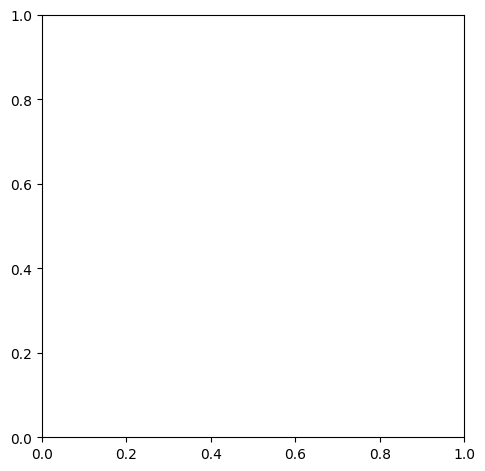

In [9]:


#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (SIZE, SIZE)))
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (SIZE, SIZE)))
plt.show()


In [7]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

model = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        720 │ input_layer[0][0] │
│                     │ 72)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │        288 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 72)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     46,728 │ batch_normalizat… │
│                     │ 72)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 512,  │          0 │ conv2d_1[0][0]    │
│                     │ 72)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 72)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     93,456 │ max_pooling2d[0]… │
│                     │ 144)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        576 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 144)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │    186,768 │ batch_normalizat… │
│                     │ 144)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256, 256,  │          0 │ conv2d_3[0][0]    │
│                     │ 144)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ dropout_1[0][0]   │
│ (MaxPooling2D)      │ 144)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    373,536 │ max_pooling2d_1[… │
│                     │ 288)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,152 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 288)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    746,784 │ batch_normalizat… │
│                     │ 288)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_5[0][0]    │
│                     │ 288)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ dropout_2[0][0]   │
│ (MaxPooling2D)      │ 288)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │  1,493,568 │ max_pooling2d_2[

 Total params: 39,285,289 (149.86 MB)

 Trainable params: 39,278,665 (149.84 MB)

 Non-trainable params: 6,624 (25.88 KB)

In [8]:
history = model.fit(X_train, y_train, batch_size = 8, verbose=1, epochs=10, validation_data=(X_test, y_test), shuffle=False)

model.save('5layerUnet.hdf5')

Epoch 1/10


2024-04-01 15:45:59.589308: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[72,72,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,72,512,512]{3,2,1,0}, f32[8,72,512,512]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-01 15:46:02.393630: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 3.804433696s
Trying algorithm eng0{} for conv (f32[72,72,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,72,512,512]{3,2,1,0}, f32[8,72,512,512]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-01 15:46:05.614587: E external/loca

61/62 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5152 - loss: 1.0874

2024-04-01 15:50:37.555779: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[72,72,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,72,512,512]{3,2,1,0}, f32[7,72,512,512]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-01 15:50:39.878299: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 3.322726553s
Trying algorithm eng0{} for conv (f32[72,72,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,72,512,512]{3,2,1,0}, f32[7,72,512,512]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-01 15:50:42.828252: E external/loca

62/62 ━━━━━━━━━━━━━━━━━━━━ 505s 4s/step - accuracy: 0.5164 - loss: 1.0974 - val_accuracy: 0.4738 - val_loss: 22.9650
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.6204 - loss: 2.4193 - val_accuracy: 0.9056 - val_loss: 0.8196
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.7050 - loss: 2.0232 - val_accuracy: 0.9218 - val_loss: 0.0034
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7835 - loss: 1.0018 - val_accuracy: 0.6126 - val_loss: 0.6736
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.8931 - loss: 0.1327 - val_accuracy: 0.9211 - val_loss: 0.0445
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9206 - loss: 0.0144 - val_accuracy: 0.9218 - val_loss: 0.0093
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9224 - loss: 0.0066 - val_accuracy: 0.9218 - val_loss: 0.0051
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9226 - loss: 0.0050 - val_accuracy: 0.9218 - val_loss: 0.0042
E

2024-04-01 16:03:41.474552: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[32,72,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,72,512,512]{3,2,1,0}, f32[72,72,3,3]{3,2,1,0}, f32[72]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-01 16:03:41.716109: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.241676399s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[32,72,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,72,512,512]{3,2,1,0}, f32[72,72,3,3]{3,2,1,0}, f32[72]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is

1/2 ━━━━━━━━━━━━━━━━━━━━ 3:23 203s/step - accuracy: 0.9281 - loss: 0.0032

2024-04-01 16:08:30.417774: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=4,k3=0} for conv (f32[23,144,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[23,288,256,256]{3,2,1,0}, f32[144,288,3,3]{3,2,1,0}, f32[144]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-01 16:08:30.481031: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.06344209s
Trying algorithm eng11{k2=4,k3=0} for conv (f32[23,144,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[23,288,256,256]{3,2,1,0}, f32[144,288,3,3]{3,2,1,0}, f32[144]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alp

2/2 ━━━━━━━━━━━━━━━━━━━━ 332s 128s/step - accuracy: 0.9239 - loss: 0.0034
Accuracy =  92.17911958694458 %


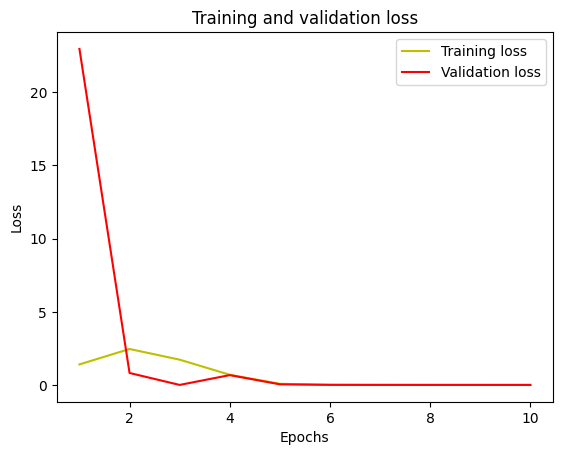

In [9]:
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

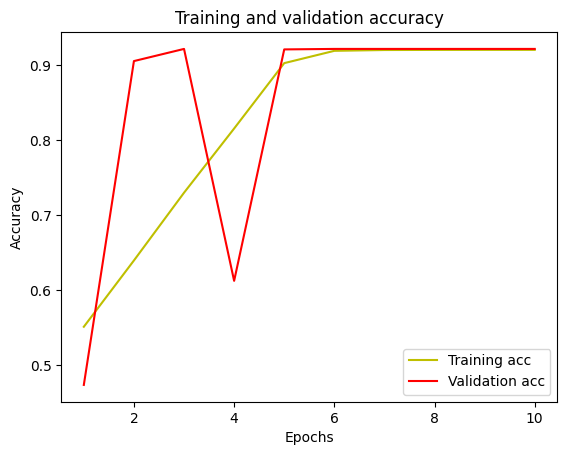

In [18]:
#acc = history.history['acc']
acc = history.history['accuracy']
#val_acc = history.history['val_acc']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [77]:
y_pred=model.predict(X_test)

intersection = np.logical_and(y_test, y_pred)
union = np.logical_or(y_test, y_pred)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)
#print(intersection.any())

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step 
IoU socre is:  0.07820878462357954


In [86]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)

In [87]:
prediction = (model.predict(test_img_input)[0,:,:,0])#.astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


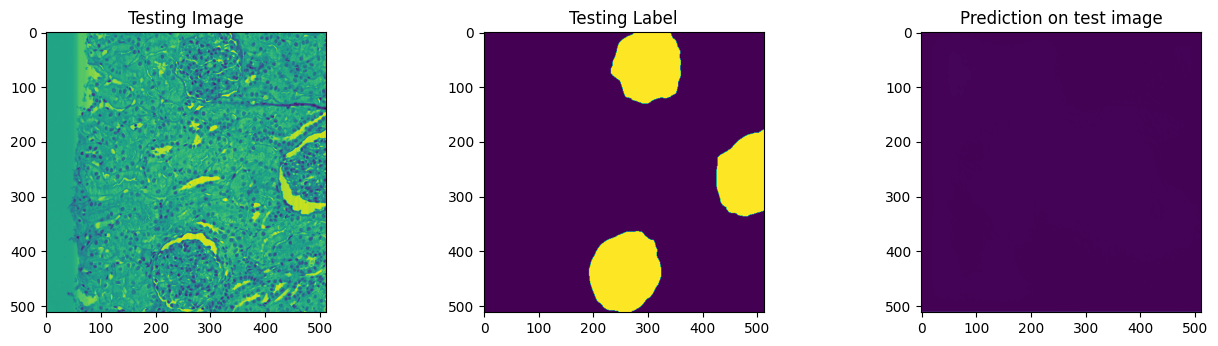

In [91]:


#test_img_other = cv2.imread('1bc.jpge',0)
#test_img_other = cv2.imread('data/test_images/img8.tif', 0)
#test_img_other_norm = np.expand_dims(normalize(np.array(test_img_other), axis=1),2)
#test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
#test_img_other_input=np.expand_dims(test_img_other_norm, 0)

#prediction_other = (model.predict(test_img_other_input)[0,:,:,0] > 0.2).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction)
"""plt.subplot(234)
plt.title('External Image')
plt.imshow(test_img_other, cmap='gray')
plt.subplot(235)
plt.title('Prediction of external Image')
plt.imshow(prediction_other, cmap='gray')"""
plt.show()

In [41]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(ground_truth.flatten(), binary_predictions.flatten(), average='binary')


ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [46]:
threshold = 0
binary_predictions = np.where(prediction >= threshold, 1, 0)

[[[[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  ...

  [[ True]
   [ True]
   [ True]
   ...
   [False]
   [False]
   [False]]

  [[ True]
   [ True]
   [ True]
   ...
   [False]
   [False]
   [False]]

  [[ True]
   [ True]
   [ True]
   ...
   [False]
   [False]
   [False]]]


 [[[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  ...

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]]


 [[[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[Fal